# Cell count demo

In this notebook, I will demonstrate three methods to perform a simple cell couting tasks and compare the results.  
The methods are;
- Classical algorithm-based approach with theresholding and watersheding (written in Python)
- Deep learning-based approach (CellPose)  # Add reference
- ImageJ macro-based approach

Ok, let's import necessary packages. Please install them according to README if necessary.

In [1]:
%load_ext autoreload
%autoreload 2

import glob

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from scripts import cell_count_contour
from cellpose import models
from cellpose import plot


And setting up paths

In [5]:
img_dir = "./imgs"
img_pths = glob.glob(f"{img_dir}/*.tif")
meta_pth = "meta/BBBC021_v1_image_wMoAs.csv"

In [6]:
img_pths

['./imgs/Week1_150607_B02_s1_w107447158-AC76-4844-8431-E6A954BD1174.tif',
 './imgs/Week1_150607_B02_s1_w23FDB0AC4-EA74-4D33-A7D4-8FFC4C9ED7C8.tif',
 './imgs/Week1_150607_B02_s1_w429636E34-C663-4E49-84B5-3EA429CAB4CE.tif']

## Dataset

In this demostration, we will use an example image from the BBBC021 dataset which <mark>xxx</mark>.  
<mark>Add descriptions and source.</mark>


### Show raw images

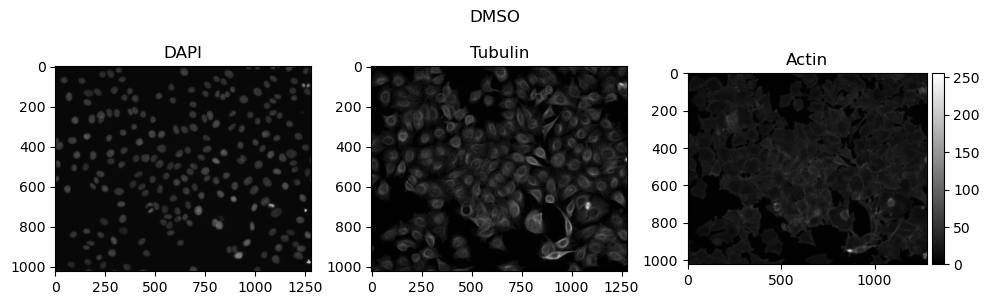

In [7]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
chs = ["DAPI", "Tubulin", "Actin"]
for i, (pth, ch) in enumerate(zip(img_pths, chs)):
    img = cv2.imread(pth, cv2.IMREAD_UNCHANGED)
    img = (((img - img.min())/(img.max() - img.min()))*255).astype(np.uint8)
    _ = ax[i].imshow(img, vmin=0, vmax=255, cmap='gray')
    ax[i].set_title(ch)
divider = make_axes_locatable(fig.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(_, cax=cax); plt.suptitle("DMSO")
plt.tight_layout(); plt.show(); plt.close('all')

## Python - algorithm based

Original image dtype: uint16
Number of cells: 203


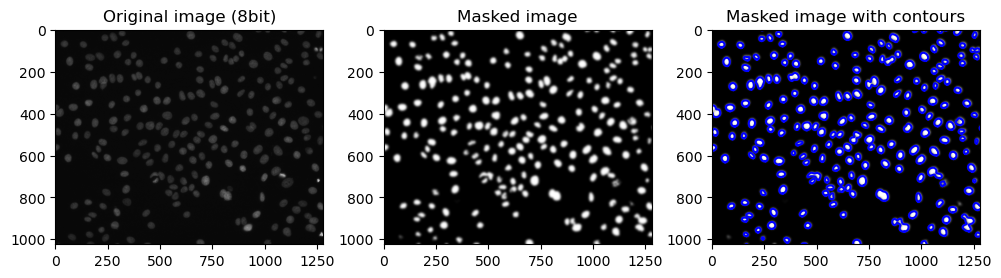

<Figure size 640x480 with 0 Axes>

In [8]:
cnts, fig = cell_count_contour(img_pths[0], mask_th=40, cnt_th=125, show_plot=True)

## Python - deep-learning based

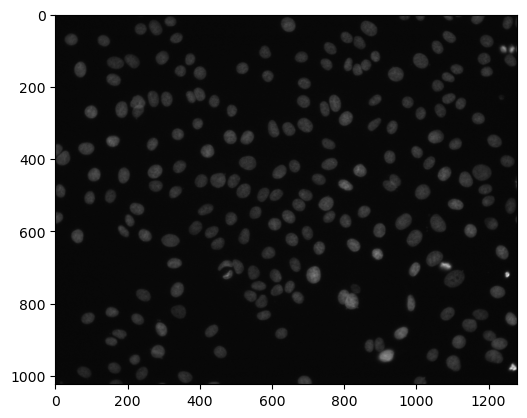

In [9]:
img = cv2.imread(img_pths[0], cv2.IMREAD_UNCHANGED)
img = (((img - img.min())/(img.max() - img.min()))*255).astype(np.uint8)
plt.imshow(img, cmap='gray')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234]


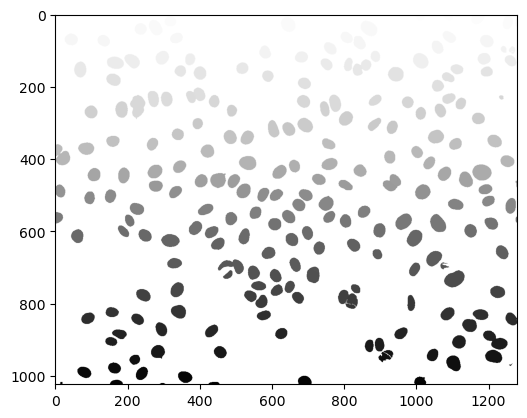

In [10]:
model = models.Cellpose(gpu=False, model_type='nuclei') # model_type='cyto' or model_type='nuclei'

# Running the models
masks, flows, styles, diams = model.eval(img, diameter=20, flow_threshold=None, channels=[0,0])
print(np.unique(masks))
plt.imshow(masks,cmap='Greys')
plt.show()


## ImageJ based

```java
fp = "/Users/RSuzuki/Projects/data/BBBC021/images/Week1_22123/Week1_150607_B02_s1_w107447158-AC76-4844-8431-E6A954BD1174.tif"
// print(fp)
open(fp);
setAutoThreshold("Default dark no-reset");
//run("Threshold...");
setOption("BlackBackground", true);
run("Convert to Mask");
run("Watershed");
run("Analyze Particles...", "  show=Outlines display clear");

```

## Summary

In [11]:
cv2.imread("/Users/RSuzuki/Projects/data/BBBC021/images/Week9_39301/Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-97BF0C969EA4.tif", cv2.IMREAD_UNCHANGED)

array([[736, 752, 784, ..., 736, 784, 848],
       [816, 784, 768, ..., 768, 784, 784],
       [704, 688, 704, ..., 784, 848, 816],
       ...,
       [768, 688, 768, ..., 720, 720, 704],
       [784, 736, 720, ..., 752, 768, 800],
       [752, 704, 768, ..., 784, 768, 832]], dtype=uint16)

## Bonus: Image-based proliferation curve

In [19]:
meta = pd.read_csv(meta_pth)
meta.head()

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moas
0,4,233,G10_s1_w1BEDC2073-A983-4B98-95E9-84466707A25D.tif,Week4/Week4_27481,G10_s1_w2DCEC82F3-05F7-4F2F-B779-C5DF9698141E.tif,Week4/Week4_27481,G10_s1_w43CD51CBC-2370-471F-BA01-EE250B14B3C8.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003,UNKNOWN
1,4,234,G10_s2_w11C3B9BCC-E48F-4C2F-9D31-8F46D8B5B972.tif,Week4/Week4_27481,G10_s2_w2570437EF-C8DC-4074-8D63-7FA3A7271FEE.tif,Week4/Week4_27481,G10_s2_w400B21F33-BDAB-4363-92C2-F4FB7545F08C.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003,UNKNOWN
2,4,235,G10_s3_w1F4FCE330-C71C-4CA3-9815-EAF9B9876EB5.tif,Week4/Week4_27481,G10_s3_w2194A9AC7-369B-4D84-99C0-DA809B0042B8.tif,Week4/Week4_27481,G10_s3_w4E0452054-9FC1-41AB-8C5B-D0ACD058991F.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003,UNKNOWN
3,4,236,G10_s4_w1747818B4-FFA7-40EE-B0A0-6A5974AF2644.tif,Week4/Week4_27481,G10_s4_w298D4652F-B5BF-49F2-BE51-8149DF83EAFD.tif,Week4/Week4_27481,G10_s4_w42648D36D-6B77-41CD-B520-6E4C533D9ABC.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003,UNKNOWN
4,4,473,G10_s1_w10034568D-CC12-43C3-93A9-DC3782099DD3.tif,Week4/Week4_27521,G10_s1_w2A29ED14B-952C-4BA1-89B9-4F92B6DADEB4.tif,Week4/Week4_27521,G10_s1_w4DAA2E9D1-F6E9-45FA-ADC0-D341B647A680.tif,Week4/Week4_27521,Week4_27521,G10,2,5-fluorouracil,0.003,UNKNOWN


In [15]:
all_cpds = meta["Image_Metadata_Compound"].unique()
idx = np.random.randint(0, len(all_cpds), 3)
cpds = all_cpds[idx]

In [16]:
print(cpds)

['deoxymannojirimycin' '5-fluorouracil' 'deoxymannojirimycin']


In [24]:
cpds = ["staurosporine", "emetine", "etoposide"]

In [26]:
meta.query("Image_Metadata_Compound == 'emetine'")

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moas
3028,3,2953,Week3_290607_C10_s1_w1B6001CE7-DC9F-4393-84DE-...,Week3/Week3_25681,Week3_290607_C10_s1_w264D8BBCC-1731-450B-9D3A-...,Week3/Week3_25681,Week3_290607_C10_s1_w4963E5F2A-E1CE-4E09-AB18-...,Week3/Week3_25681,Week3_25681,C10,1,emetine,0.01,Protein synthesis
3029,3,2954,Week3_290607_C10_s2_w194A8FB28-4482-4EDC-A58B-...,Week3/Week3_25681,Week3_290607_C10_s2_w26B931171-F64A-4BFC-828A-...,Week3/Week3_25681,Week3_290607_C10_s2_w4844DFAD7-C2F9-4531-8D68-...,Week3/Week3_25681,Week3_25681,C10,1,emetine,0.01,Protein synthesis
3030,3,2955,Week3_290607_C10_s3_w19CB72A45-A40E-49F2-BA24-...,Week3/Week3_25681,Week3_290607_C10_s3_w2EED89A66-8EF5-4991-B30B-...,Week3/Week3_25681,Week3_290607_C10_s3_w44153CB1F-D74E-4463-8B1C-...,Week3/Week3_25681,Week3_25681,C10,1,emetine,0.01,Protein synthesis
3031,3,2956,Week3_290607_C10_s4_w1FF986D28-70F7-4B3D-8765-...,Week3/Week3_25681,Week3_290607_C10_s4_w284EE3D4F-EDF3-4B30-B457-...,Week3/Week3_25681,Week3_290607_C10_s4_w435E553C6-DA91-444E-8531-...,Week3/Week3_25681,Week3_25681,C10,1,emetine,0.01,Protein synthesis
3032,3,3193,Week3_290607_C10_s1_w1BDEEAD65-EE5A-4FA4-A32E-...,Week3/Week3_25701,Week3_290607_C10_s1_w2A279C4CE-C2E3-43C9-BCC8-...,Week3/Week3_25701,Week3_290607_C10_s1_w49B64BA73-9FEF-4748-8033-...,Week3/Week3_25701,Week3_25701,C10,2,emetine,0.01,Protein synthesis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,3,3180,Week3_290607_C06_s4_w17AB2F316-96FE-432C-9ABF-...,Week3/Week3_25701,Week3_290607_C06_s4_w21097109D-6B1F-4C5A-8524-...,Week3/Week3_25701,Week3_290607_C06_s4_w49916B999-D6D9-4F5F-A934-...,Week3/Week3_25701,Week3_25701,C06,2,emetine,1.00,Protein synthesis
11876,3,3417,Week3_290607_C06_s1_w16863C3CE-84DD-41E7-9F58-...,Week3/Week3_25721,Week3_290607_C06_s1_w2310D60E4-22D5-4B90-BDAE-...,Week3/Week3_25721,Week3_290607_C06_s1_w4BDA6E64E-196C-411B-BE46-...,Week3/Week3_25721,Week3_25721,C06,3,emetine,1.00,Protein synthesis
11877,3,3418,Week3_290607_C06_s2_w189AE7C06-F7C3-4782-AC20-...,Week3/Week3_25721,Week3_290607_C06_s2_w2D3269E69-AF4D-4F46-BA52-...,Week3/Week3_25721,Week3_290607_C06_s2_w4CE40326F-930B-4CCD-9299-...,Week3/Week3_25721,Week3_25721,C06,3,emetine,1.00,Protein synthesis
11878,3,3419,Week3_290607_C06_s3_w1F5D1CAB0-4CEB-45C4-B63D-...,Week3/Week3_25721,Week3_290607_C06_s3_w2F3F67255-B9FF-4CDD-A728-...,Week3/Week3_25721,Week3_290607_C06_s3_w451F3E9B7-356A-459E-AD69-...,Week3/Week3_25721,Week3_25721,C06,3,emetine,1.00,Protein synthesis


0 staurosporine
['imgs/Week3_25421/Week3_290607_C10_s1_w11BCD4A99-B81F-414C-9380-713EB64AA11D.tif', 'imgs/Week3_25421/Week3_290607_C10_s2_w1058F1D0F-5CC9-4D74-A95E-F0773E355532.tif', 'imgs/Week3_25421/Week3_290607_C10_s3_w1697FEE23-BE87-4E8E-AB63-70FD7FC42115.tif', 'imgs/Week3_25421/Week3_290607_C10_s4_w15E92D5FD-590C-43F2-8214-7C26230D645D.tif', 'imgs/Week3_25441/Week3_290607_C10_s1_w169B32C74-7F8A-4D82-9E66-7278AE889B87.tif', 'imgs/Week3_25441/Week3_290607_C10_s2_w1F9BF5CC8-3D2F-4C5B-85A4-2F85DB02EDA5.tif', 'imgs/Week3_25441/Week3_290607_C10_s3_w1CDE1BCF2-1803-4FD3-A0EC-1610E45D9BCF.tif', 'imgs/Week3_25441/Week3_290607_C10_s4_w15289F255-42B2-468A-B4E3-17084953C700.tif', 'imgs/Week3_25461/Week3_290607_C10_s1_w10B8E75DE-18C4-48F0-9AFF-94F98CF854B5.tif', 'imgs/Week3_25461/Week3_290607_C10_s2_w1EF48C8D3-083B-4303-A3FC-8F0EF3F967F2.tif', 'imgs/Week3_25461/Week3_290607_C10_s3_w118053A50-F44C-4868-8854-0F419B0081AA.tif', 'imgs/Week3_25461/Week3_290607_C10_s4_w18059FFB1-5030-42E7-A58F-FA550E

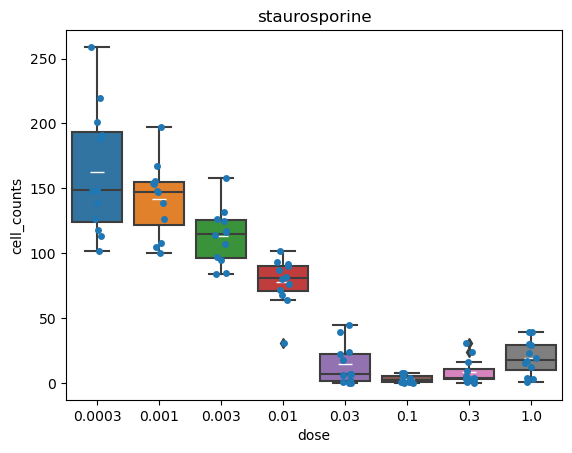

1 emetine
['imgs/Week3_25681/Week3_290607_C10_s1_w1B6001CE7-DC9F-4393-84DE-2466C16A9D0E.tif', 'imgs/Week3_25681/Week3_290607_C10_s2_w194A8FB28-4482-4EDC-A58B-540111BF2C89.tif', 'imgs/Week3_25681/Week3_290607_C10_s3_w19CB72A45-A40E-49F2-BA24-E700C929057F.tif', 'imgs/Week3_25681/Week3_290607_C10_s4_w1FF986D28-70F7-4B3D-8765-3E482486F576.tif', 'imgs/Week3_25701/Week3_290607_C10_s1_w1BDEEAD65-EE5A-4FA4-A32E-AFD9A0239B23.tif', 'imgs/Week3_25701/Week3_290607_C10_s2_w17FE7E736-A723-4FD4-985C-CE536826E09C.tif', 'imgs/Week3_25701/Week3_290607_C10_s3_w12D90F8BA-E2B0-42C8-B4D5-2173119797B4.tif', 'imgs/Week3_25701/Week3_290607_C10_s4_w1A5FEDAC4-454E-42D7-B472-2684685C89F7.tif', 'imgs/Week3_25721/Week3_290607_C10_s1_w16B665FC9-BE88-47E0-B704-24F5A5222308.tif', 'imgs/Week3_25721/Week3_290607_C10_s2_w14A4A3A02-57AA-4A68-B11C-ED3364ACC653.tif', 'imgs/Week3_25721/Week3_290607_C10_s3_w1CF60813A-C4C9-4489-90FB-3B71C0B2BFEE.tif', 'imgs/Week3_25721/Week3_290607_C10_s4_w1C8F752D5-8A8D-4D70-AF77-900FE84D9E00

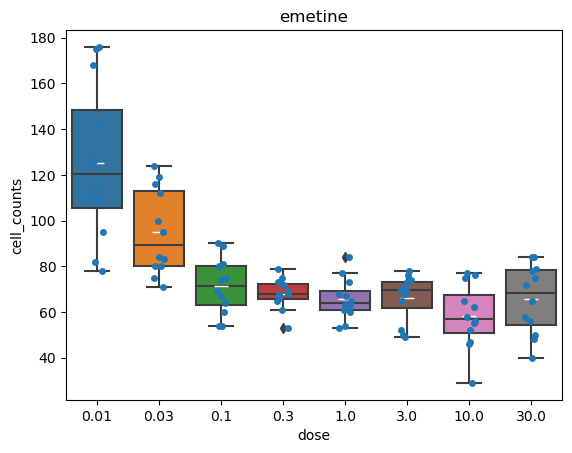

2 etoposide
['imgs/Week3_25421/Week3_290607_F10_s1_w1BF251675-29F8-4934-8353-8790B446BB4A.tif', 'imgs/Week3_25421/Week3_290607_F10_s2_w18B7C768A-F517-47CA-BB5E-89F1520709D6.tif', 'imgs/Week3_25421/Week3_290607_F10_s3_w1F4937659-2CE0-4A7D-AC59-3D3EBAF0CE7B.tif', 'imgs/Week3_25421/Week3_290607_F10_s4_w14854B7AB-C4FF-40F2-BFBD-79E430489355.tif', 'imgs/Week3_25441/Week3_290607_F10_s1_w17FB959EA-2E43-4F74-B4FC-B3E92E792D13.tif', 'imgs/Week3_25441/Week3_290607_F10_s2_w1BF80D04E-7563-4EE6-A11E-6D40215F1326.tif', 'imgs/Week3_25441/Week3_290607_F10_s3_w1C5A79CE9-A29A-491B-AD7C-D8F6E532E979.tif', 'imgs/Week3_25441/Week3_290607_F10_s4_w1A4A5377C-F656-47C3-9CF7-1598280D444C.tif', 'imgs/Week3_25461/Week3_290607_F10_s1_w1116FD6D0-F20F-406E-8C6D-25EFE1CBF85F.tif', 'imgs/Week3_25461/Week3_290607_F10_s2_w11D48AF3A-FD27-4F3F-BC46-F458815D8807.tif', 'imgs/Week3_25461/Week3_290607_F10_s3_w13D6DC495-588D-4F61-A469-3B73819D0FB9.tif', 'imgs/Week3_25461/Week3_290607_F10_s4_w11D217088-1242-44DE-B4C3-AA6C6A7CBA

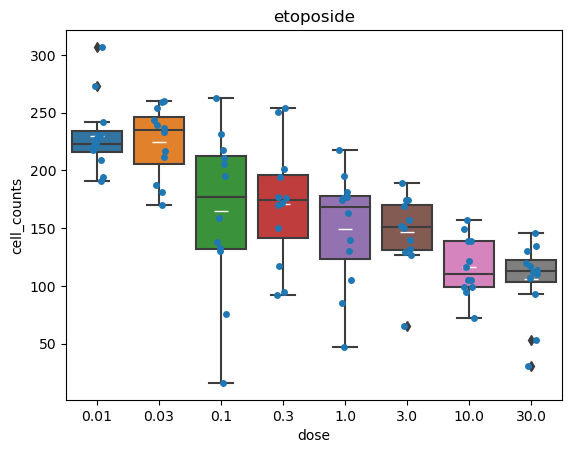

In [28]:

for i, cpd in enumerate(cpds):
    print(i, cpd)
    cntrs = np.sort(meta.query("Image_Metadata_Compound == @cpd")["Image_Metadata_Concentration"].unique())
    ch = "DAPI"
    doses = []
    cell_cnts = []
    for cntr in cntrs:
        meta2 = meta.query("Image_Metadata_Compound == @cpd and Image_Metadata_Concentration == @cntr")
        img_paths1 = meta2[f"Image_Metadata_Plate_DAPI"].values
        img_paths2 = meta2[f"Image_FileName_{ch}"].values
        img_paths = [f"imgs/{one}/{two}" for one, two in zip(img_paths1, img_paths2)]
        doses.extend([cntr]*len(img_paths))
        for ip in img_paths:
            cnts = cell_count_contour(ip, mask_th=40, cnt_th=125, show_plot=False)
            cell_cnts.append(cnts)
    show_dmso = False
    df = pd.DataFrame({"dose": doses, "cell_counts": cell_cnts})
    ## Boxplot
    sns.boxplot(x="dose", y="cell_counts", data=df, showmeans=True, dodge=True, meanprops={"marker":"_", "markeredgecolor":"white", "markersize":"10"}).set_title(f"{cpd}")
    sns.stripplot(x='dose', y='cell_counts', data=df, jitter=True)
    plt.show()